Basin hopping Global Optimisation
=================================

Knowledge 
- https://machinelearningmastery.com/basin-hopping-optimization-in-python/

Random note
-----------
Take background as negative excursion

1) find background and modulation settings at x contrast
2) Use background and modulation settings as upper and lower bounds to find settings y%, where y% < x%
3) Use background and modulation settings at Y% as starting point for next Y%

Basic example with rosenbrock
-----------------------------

In [1]:
import sys
sys.path.insert(0, '../')
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import basinhopping, Bounds
from scipy.interpolate import interp1d

from silentsub.device import StimulationDevice
from silentsub.plotting import stim_plot
from silentsub.CIE import get_CIES026

sns.set_context('notebook')
sns.set_style('whitegrid')


Load the data with `StimulationDevice`
--------------------------------------

In [6]:
spds = pd.read_csv('../data/S2_corrected_oo_spectra.csv', index_col=['led','intensity'])
spds.index.rename(['Primary', 'Setting'], inplace=True)
spds.columns = pd.Int64Index(spds.columns.astype(int))

# list of colors for the primaries
colors = ['blueviolet', 'royalblue', 'darkblue', 'blue', 'cyan', 
          'green', 'lime', 'orange', 'red', 'darkred']

# instantiate the class
device = StimulationDevice(
    resolutions=[4095]*10,
    colors=colors,
    spds=spds,
    spd_binwidth=1)

Define optimisation problem
---------------------------

This is the 'basic' optimisation where we aim to maximise melanopic contrast whilst keeping cone contrast at zero.

In [9]:
aopic = spds.dot(get_CIES026())
aopic

S         M         L             R             I
Primary Setting                                                              
0       0        1.652849e-10  0.000008  0.000034  6.066599e-07  7.991283e-08
        65       4.464621e-02  0.003514  0.002485  1.233052e-02  1.564583e-02
        130      1.260046e-01  0.011021  0.008438  3.573582e-02  4.506167e-02
        195      2.300100e-01  0.022206  0.017821  6.708515e-02  8.387576e-02
        260      4.486615e-01  0.046677  0.038688  1.338053e-01  1.662003e-01
...                       ...       ...       ...           ...           ...
9       3835     1.131181e-01  0.303766  1.638506  1.512043e-01  1.372340e-01
        3900     1.098176e-01  0.303805  1.666707  1.467185e-01  1.325618e-01
        3965     1.124645e-01  0.308965  1.682529  1.508817e-01  1.363681e-01
        4030     1.106837e-01  0.306781  1.680621  1.482401e-01  1.337844e-01
        4095     1.136898e-01  0.312333  1.699980  1.526881e-01  1.381907e-01

[640 rows x 5 columns]

In [3]:
class OptimisationProblem:
    def __init__(self, aopic):
        self.aopic = aopic

    def smlri_calculator(self, weights):
        '''Calculates a-opic irradiance for the given weights.
        The first 10 values in weights define the background
        spectrum and the second 10 values define the modulation'''
        background = weights[0:10]
        modulation = weights[10:20]
        bg_smlri = 0
        mod_smlri = 0
        for led in range(10):
            x = self.aopic.loc[led].index / 4095
            y = self.aopic.loc[led]
            f = interp1d(x, y, axis=0, fill_value='extrapolate')
            bg_smlri += f(background[led])
            mod_smlri += f(modulation[led])
        return (pd.Series(bg_smlri, index=self.aopic.columns, name='Background'),
                pd.Series(mod_smlri, index=self.aopic.columns, name='Modulation'))

    def objective_function(self, weights, target_contrast=2.):
        '''Calculates negative melanopsin contrast for background
        and modulation spectra. We want to minimise this.'''
        bg_smlri, mod_smlri = self.smlri_calculator(weights)
        contrast = (mod_smlri.I-bg_smlri.I) / bg_smlri.I
        if target_contrast:
            return pow(contrast-target_contrast, 2)
        else:
            return -contrast
        
    def cone_contrast_constraint_function(self, weights):
        '''Calculates S-, M-, and L-opic contrast for background
        and modulation spectra. We want to this to be zero'''
        bg_smlri, mod_smlri = self.smlri_calculator(weights)
        contrast = np.array([(mod_smlri.S-bg_smlri.S) / bg_smlri.S,
                             (mod_smlri.M-bg_smlri.M) / bg_smlri.M,
                             (mod_smlri.L-bg_smlri.L) / bg_smlri.L])
        return contrast

    def weights_to_settings(self, weights):
        '''Turns weights to 12-bit STLAB settings.'''
        return ([int(val*4095) for val in weights[0:10]],
                [int(val*4095) for val in weights[10:20]])

In [15]:
x0 = np.random.rand(1, 20)[0]
op = OptimisationProblem(aopic)
bg, mod = op.smlri_calculator(x0)

In [19]:
op.cone_contrast_constraint_function(x0)

array([ 0.34793224,  1.33262633,  0.86160832])

Do optimisation
---------------

In [14]:
(mod[['S', 'M']] - bg[['S', 'M']]) / bg[['S', 'M']]

S   -0.244047
M    0.510960
dtype: float64

basinhopping step 0: f 1.24797


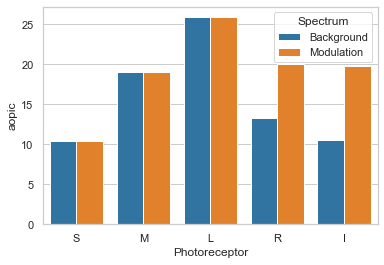

basinhopping step 1: f 1.02107 trial_f 1.02107 accepted 1  lowest_f 1.02107
found new global minimum on step 1 with function value 1.02107


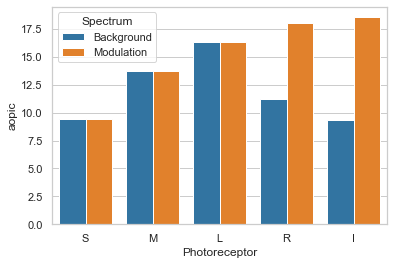

basinhopping step 2: f 1.02007 trial_f 1.02007 accepted 1  lowest_f 1.02007
found new global minimum on step 2 with function value 1.02007


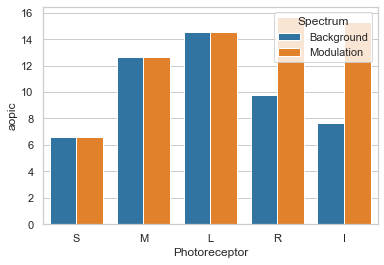

basinhopping step 3: f 0.301741 trial_f 0.301741 accepted 1  lowest_f 0.301741
found new global minimum on step 3 with function value 0.301741


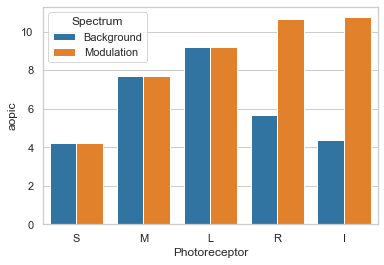

basinhopping step 4: f 0.566456 trial_f 0.566456 accepted 1  lowest_f 0.301741


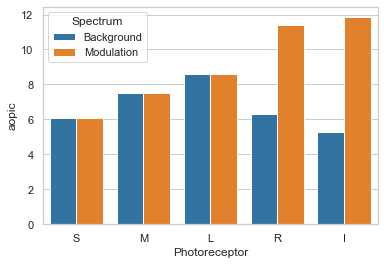

basinhopping step 5: f 0.0645259 trial_f 0.0645259 accepted 1  lowest_f 0.0645259
found new global minimum on step 5 with function value 0.0645259


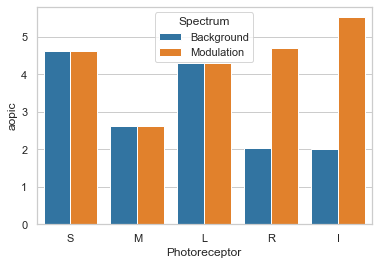

basinhopping step 6: f 0.0645259 trial_f 0.277099 accepted 0  lowest_f 0.0645259


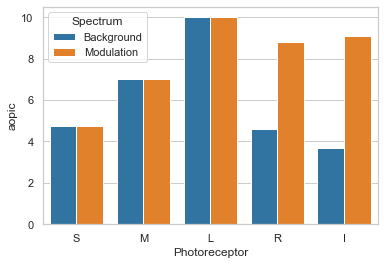

basinhopping step 7: f 0.0375088 trial_f 0.0375088 accepted 1  lowest_f 0.0375088
found new global minimum on step 7 with function value 0.0375088


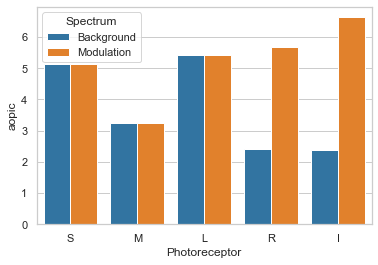

basinhopping step 8: f 0.0375088 trial_f 0.458722 accepted 0  lowest_f 0.0375088


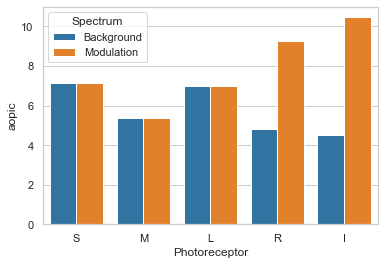

basinhopping step 9: f 0.0375088 trial_f 0.355307 accepted 0  lowest_f 0.0375088


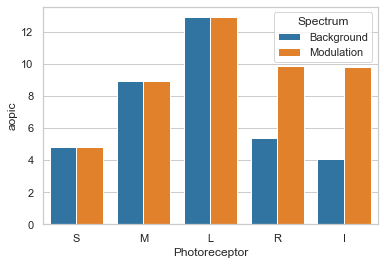

basinhopping step 10: f 5.09336e-11 trial_f 5.09336e-11 accepted 1  lowest_f 5.09336e-11
found new global minimum on step 10 with function value 5.09336e-11


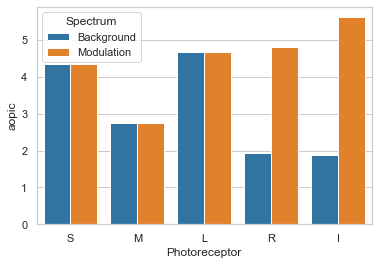

In [5]:
# A random starting point for the optimisation
x0 = np.random.rand(1, 20)[0]

op = OptimisationProblem(device.aopic)

constraints = ({
    'type': 'eq',
    'fun': lambda x: op.cone_contrast_constraint_function(x)
})

# The bounds should be between 0-1, otherwise we are outside the
# gamut of the device
bounds = [(0, 1.),] * 20

# Plotting func for call back
def plot_solution(background, modulation, ax=None):
    df = (
        pd.concat([background, modulation], axis=1)
        .T.melt(
            value_name='aopic',
            var_name='Photoreceptor',
            ignore_index=False)
        .reset_index()
        .rename(
            columns={'index': 'Spectrum'})
         )
    fig = sns.barplot(data=df, x='Photoreceptor', y='aopic', hue='Spectrum')
    plt.show()

# List to store valid solutions
minima = []

def print_fun(x, f, accepted):
    bg, mod = op.smlri_calculator(x)
    plot_solution(bg, mod)
    if accepted:
        minima.append(x)
        if f < .0001 and accepted: # For now, this is how we define our tollerance
            return True
        
minimizer_kwargs = {
    'method': 'SLSQP',
    'bounds': bounds,
    'options': {'maxiter': 500},
    'constraints': constraints
}
    
# Do basinhopping
res = basinhopping(
    func=op.objective_function,
    x0=x0,
    niter=100,
    T=1.0,
    stepsize=0.5,
    minimizer_kwargs=minimizer_kwargs,
    take_step=None,
    accept_test=None,
    callback=print_fun,
    interval=50,
    disp=True,
    niter_success=None,
    seed=None,
)

In [6]:
def plot_solution(background, modulation, ax=None):
    df = (
        pd.concat([background, modulation], axis=1)
        .T.melt(
            value_name='aopic',
            var_name='Photoreceptor',
            ignore_index=False)
        .reset_index()
        .rename(
            columns={'index': 'Spectrum'})
         )
    sns.barplot(data=df, x='Photoreceptor', y='aopic', hue='Spectrum', ax=ax)

<AxesSubplot:>

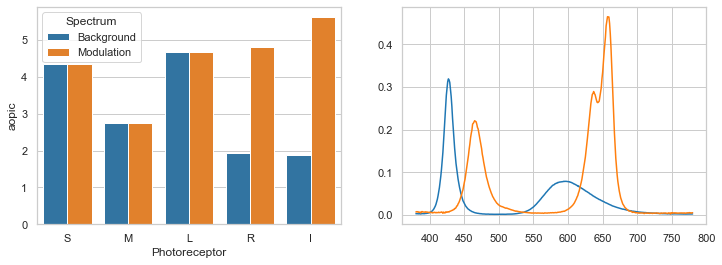

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

bg_ao = device.predict_multiprimary_aopic(res.x[0:10], name='Background')
mod_ao = device.predict_multiprimary_aopic(res.x[10:20], name='Modulation')


bg_spd = device.predict_multiprimary_spd(res.x[0:10], name='Background')
mod_spd = device.predict_multiprimary_spd(res.x[10:20], name='Modulation')

plot_solution(bg_ao.T.squeeze(), mod_ao.T.squeeze(), ax=axs[0])

bg_spd.T.plot(ax=axs[1])
mod_spd.T.plot(ax=axs[1])

Gets weird now
--------------

Lower number as lower bound and upper number as higher bound

In [10]:
bg = res.x[0:10]
mod = res.x[10:20]
new_bounds = [(min(val), max(val)) for val in zip(bg, mod)]
new_bounds

[(0.0, 0.88797167609536454),
 (6.7762635780344027e-20, 0.00013844345638604373),
 (1.2197274440461925e-19, 0.56638442939242828),
 (0.0, 0.15301338922652657),
 (0.0, 0.029108518481303979),
 (0.00022070553001490398, 0.010076712700990632),
 (6.1737992194003526e-06, 0.00064711864068266894),
 (0.015458346215679286, 0.28602546542352819),
 (0.00028355041544540988, 0.64904134418923287),
 (0.0019493840893110631, 0.99994427584816403)]

In [27]:
bg

array([  8.87971676e-01,   1.38443456e-04,   1.21972744e-19,
         0.00000000e+00,   0.00000000e+00,   2.20705530e-04,
         6.47118641e-04,   2.86025465e-01,   2.83550415e-04,
         1.94938409e-03])

In [23]:
class NewOptimisationProblem:
    def __init__(self, aopic, background):
        self.aopic = aopic
        self.background = background

    def smlri_calculator(self, weights):
        '''Calculates a-opic irradiance for the given weights.
        The first 10 values in weights define the background
        spectrum and the second 10 values define the modulation'''
        smlri = 0
        for led in range(10):
            x = self.aopic.loc[led].index / 4095
            y = self.aopic.loc[led]
            f = interp1d(x, y, axis=0, fill_value='extrapolate')
            smlri += f(weights[led])
        return pd.Series(smlri, index=self.aopic.columns, name='Modulation')

    def objective_function(self, weights, target_contrast=None):
        '''Calculates negative melanopsin contrast for background
        and modulation spectra. We want to minimise this.'''
        bg_smlri = self.smlri_calculator(self.background)
        mod_smlri = self.smlri_calculator(weights)
        contrast = (mod_smlri.I-bg_smlri.I) / bg_smlri.I
        if target_contrast:
            return contrast-target_contrast
        else:
            return -contrast
        
    def cone_contrast_constraint_function(self, weights):
        '''Calculates S-, M-, and L-opic contrast for background
        and modulation spectra. We want to this to be zero'''
        bg_smlri = self.smlri_calculator(self.background)
        mod_smlri = self.smlri_calculator(weights)
        contrast = np.array([(mod_smlri.S-bg_smlri.S) / bg_smlri.S,
                             (mod_smlri.M-bg_smlri.M) / bg_smlri.M,
                             (mod_smlri.L-bg_smlri.L) / bg_smlri.L])
        return contrast

    def weights_to_settings(self, weights):
        '''Turns weights to 12-bit STLAB settings.'''
        return ([int(val*4095) for val in weights[0:10]],
                [int(val*4095) for val in weights[10:20]])

In [56]:
from scipy.optimize import minimize

# Linear contrast gradient (for now)
contrast_gradient = np.linspace(2, 0, 10)

# Constraints for SLSQP
constraints = {
    'type': 'eq',
    'fun': lambda x: nop.cone_contrast_constraint_function(x)
}

# List for solutions
solutions = {}

# New objective with built-in background
nop = NewOptimisationProblem(device.aopic, bg)

for i, contrast in enumerate(contrast_gradient[1:-1]):
    if i==0:
        x0 = bg
    else:
        x0 = previous_solution
    print(f'Target contrast: {contrast}') 
    
    r = minimize(
        fun=nop.objective_function,
        x0=x0,
        args=(contrast),
        method='SLSQP',
        jac=None,
        hess=None,
        hessp=None,
        bounds=new_bounds,
        constraints=constraints,
        tol=.0000001,
        callback=None,
        options={'maxiter': 500, 'disp': True},
    )
    previous_solution = r.x
    solutions[i] = r

Target contrast: 1.7777777777777777


/Users/jtm545/opt/anaconda3/envs/silsub/lib/python3.7/site-packages/scipy/optimize/optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.7886418975e-15
            Iterations: 12
            Function evaluations: 137
            Gradient evaluations: 12
Target contrast: 1.5555555555555556
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.86086722213e-15
            Iterations: 9
            Function evaluations: 103
            Gradient evaluations: 9
Target contrast: 1.3333333333333335
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.36945225048e-15
            Iterations: 19
            Function evaluations: 233
            Gradient evaluations: 19
Target contrast: 1.1111111111111112
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.67266287593e-05
            Iterations: 55
            Function evaluations: 680
            Gradient evaluations: 55
Target contrast: 0.8888888888888888
Optimization termin

Solution: 0
Solution: 1
Solution: 2
Solution: 3
Solution: 4
Solution: 5
Solution: 6
Solution: 7


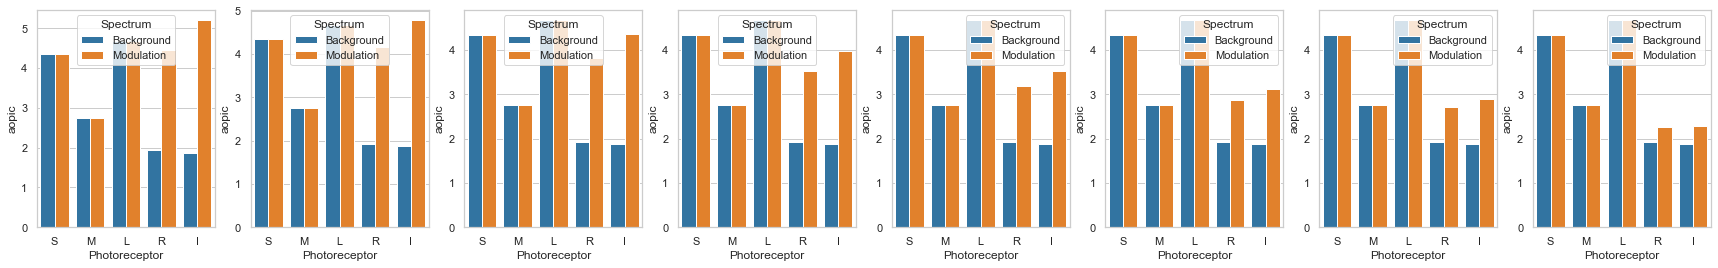

In [57]:
fig, axs = plt.subplots(1, len(solutions), figsize=(30, 4))

for i in solutions.keys():
    print(f'Solution: {i}')
    b = nop.smlri_calculator(bg)
    b.name = 'Background'
    m = nop.smlri_calculator(solutions[i]['x'])
    plot_solution(b, m, ax=axs[i])

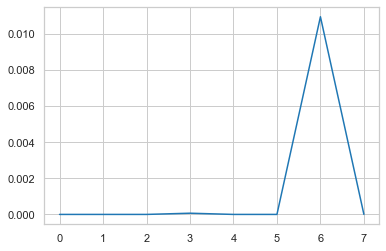

In [58]:
plt.plot([solutions[key]['fun'] for key in solutions.keys()])